In [ ]:
#model with reduced dense layers

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
from keras.utils import Sequence
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense


In [3]:
train_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\train"
img_size=128
batch_size=64

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
class MergedGenerators(Sequence):
    def __init__(self, generators):
        self.generators = generators
        self.lengths = [len(gen) for gen in generators]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, index):
        generator_index = np.argmax(index < self.cumulative_lengths)
        if generator_index > 0:
            sample_index = index - self.cumulative_lengths[generator_index - 1]
        else:
            sample_index = index

        # Get the data and labels from the corresponding generator
        data, labels = self.generators[generator_index][sample_index]
        return data, labels

In [7]:
def grayscale_conversion(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Repeat the single channel across three channels
    grayscale_image = np.stack((grayscale_image,) * 3, axis=-1)
    return grayscale_image

In [8]:
normal_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)
noisy_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),  # Add noise
)
shaded_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=[0.5, 1.5],  # Adjust the range for shading
)
grayscale_datagen = ImageDataGenerator(
    preprocessing_function= grayscale_conversion,
    rescale=1.0 / 255,
)

In [9]:
generator1 = normal_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)
generator2 = shaded_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)
generator3 = noisy_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)
generator4 = grayscale_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.
Found 8400 images belonging to 5 classes.


In [ ]:
"""
# Get a batch of images from the generator
batch_images, batch_labels = generator4.next()

# Set the number of images to display in each row
num_images_per_row = 8

# Calculate the number of rows needed
num_rows = int(len(batch_images) / num_images_per_row) + 1

# Display the images
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(200, 200))

# Flatten the axes array if there is only one row
if num_rows == 1:
    axes = axes.reshape(1, -1)

for i in range(len(batch_images)):
    row_index = i // num_images_per_row
    col_index = i % num_images_per_row
    axes[row_index, col_index].imshow(batch_images[i])
    axes[row_index, col_index].axis('off')
plt.show()
"""

In [11]:
combined_generator = MergedGenerators([generator1, generator2, generator3, generator4])

In [12]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[img_size, img_size, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [13]:
test_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\val"
test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2400 images belonging to 5 classes.


In [14]:
history=cnn.fit(x = combined_generator, validation_data = test_generator, epochs = 5)

Epoch 1/5
528/528 [==============================] - 168s 287ms/step - loss: 0.1964 - accuracy: 0.8009 - val_loss: 0.0418 - val_accuracy: 0.9700
Epoch 2/5
528/528 [==============================] - 142s 268ms/step - loss: 0.0540 - accuracy: 0.9588 - val_loss: 0.0270 - val_accuracy: 0.9771
Epoch 3/5
528/528 [==============================] - 142s 269ms/step - loss: 0.0326 - accuracy: 0.9762 - val_loss: 0.0279 - val_accuracy: 0.9808
Epoch 4/5
528/528 [==============================] - 146s 276ms/step - loss: 0.0211 - accuracy: 0.9848 - val_loss: 0.0244 - val_accuracy: 0.9796
Epoch 5/5
528/528 [==============================] - 167s 316ms/step - loss: 0.0198 - accuracy: 0.9866 - val_loss: 0.0244 - val_accuracy: 0.9821


In [18]:
cnn.save(r'C:\Users\Acer\Desktop\Minor Project\Model_v2.h5')

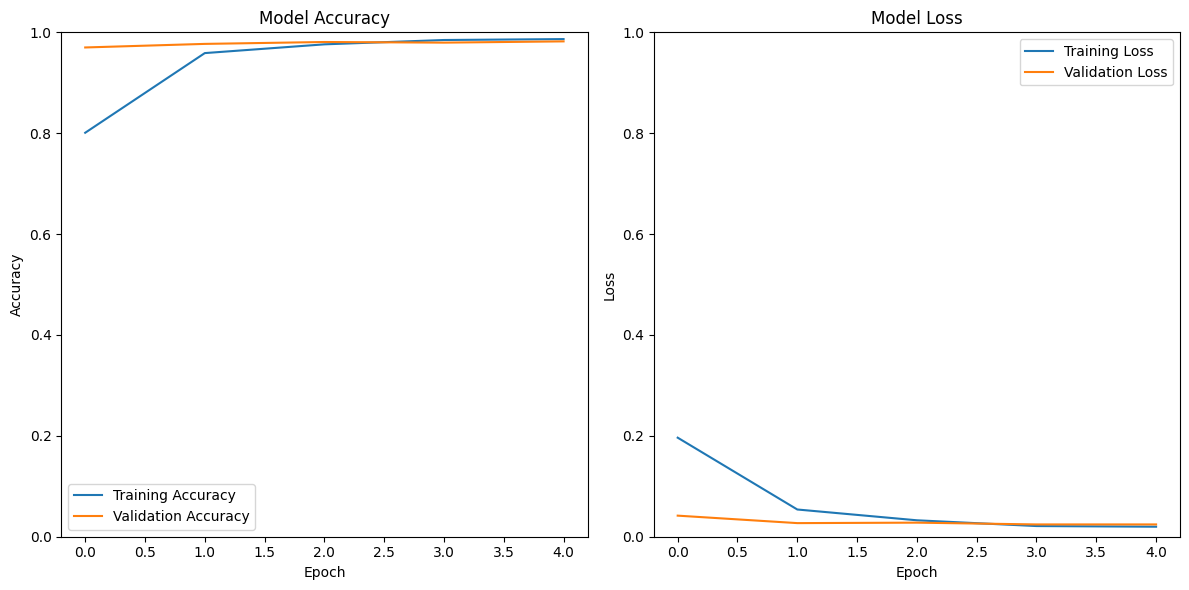

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0, 1.0)
# Show the plots
plt.tight_layout()
plt.show()

In [3]:
import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
# Load the pre-trained model
model_path = r'C:\Users\Acer\Desktop\Minor Project\Model_v2.h5'
model = load_model(model_path)
model.summary()
# Set the path to your test dataset
test_data_dir = r'C:\Users\Acer\Desktop\Minor Project\Split\test'

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 64)                1

NameError: name 'ImageDataGenerator' is not defined